In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

device = seed.device
generator = seed.generator

In [2]:
X, y, X_test, y_test = fn.load_cifar_10()

/home/z2qin/.local/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [3]:
class Muon(torch.optim.Muon):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        for g in self.param_groups:
            g["adjust_lr_fn"] = "none"

In [4]:
def newtonschulz5(G, steps=5, eps=1e-7, use_bfloat16=True):
    assert G.ndim == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.to(torch.bfloat16) if use_bfloat16 else G
    X = X / (X.norm() + eps)
    transposed = False
    if G.size(0) > G.size(1):
        X = X.T
        transposed = True
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X
    if transposed:
        X = X.T
    return X.to(G.dtype)

def max_muon_layer_sharpness(model, opt_muon, criterion, X, y, generator,
                             subsample_dim=1024, iters=30, tol=1e-4):
    # get muon weight matrices
    ps = [p for g in opt_muon.param_groups for p in g["params"]]
    # keep only 2D (weight matrices)
    muon_ws = [p for p in ps if p.ndim == 2]
    if len(muon_ws) == 0:
        raise ValueError("No 2D Muon parameters found in opt_muon.")

    # subsample
    n = X.shape[0]
    m = min(subsample_dim, n)
    idx = torch.randperm(n, device=X.device, generator=generator)[:m]
    Xs, ys = X[idx], y[idx]

    # forward once
    outputs = model(Xs)
    loss = criterion(outputs, ys)

    def power_iteration_for_param(W):
        # grad wrt W
        (gW,) = torch.autograd.grad(loss, W, create_graph=True, retain_graph=True)
        g_flat = gW.reshape(-1)
        dim = g_flat.numel()
        device = g_flat.device

        def Hv(v):
            # Hessian-vector product wrt W only
            (hW,) = torch.autograd.grad(g_flat @ v, W, retain_graph=True)
            return hW.reshape(-1)

        v = torch.randn(dim, device=device, generator=generator)
        v = v / (v.norm() + 1e-12)

        eig_old = 0.0
        for _ in range(iters):
            w = Hv(v)
            eig = (v @ w).item()
            v = w / (w.norm() + 1e-12)

            if abs(eig - eig_old) / (abs(eig_old) + 1e-12) < tol:
                break
            eig_old = eig

        w = Hv(v)
        return (v @ w).item()

    # compute per-muon-layer sharpness and take max
    lambdas = [power_iteration_for_param(W) for W in muon_ws]
    return max(lambdas)

def train_muon_model(model, opt_muon, opt_adam, criterion, epochs, accuracy, 
                     X, y, X_test, y_test, output_dir, generator):
    """Trains the provided model with the specified optimizer and criterion for 
    a set number of epochs or until the desired accuracy is reached. Records 
    training loss, training accuracy, test accuracy, and sharpness metrics at 
    each epoch.

    Args:
        model (_type_): The neural network model to train
        opt_muon (_type_): The Muon optimizer used for training
        opt_adam (_type_): The Adam optimizer used for training
        criterion (_type_): The loss function used for training
        epochs (_type_): The maximum number of training epochs
        accuracy (_type_): The target accuracy to stop training early
        X (_type_): Training input data
        y (_type_): Training target labels
        X_test (_type_): Test input data
        y_test (_type_): Test target labels
        output_dir (_type_): Directory to save output files
        generator (_type_): Random number generator for reproducibility
    """
    print(f"Training {model.__class__.__name__} with " +
          f"{opt_muon.__class__.__name__} and learning rate " +
          f"{opt_muon.param_groups[0]['lr']} for {epochs} epochs.")

    learning_rate = opt_muon.param_groups[0]['lr']
    momentum = opt_muon.param_groups[0].get('momentum', 0.0)

    model.to(device)
    model.train()

    train_losses = np.full(epochs, np.nan)
    train_accuracies = np.full(epochs, np.nan)
    test_accuracies = np.full(epochs, np.nan)
    H_sharps = np.full(epochs, np.nan)
    A_sharps = np.full(epochs, np.nan)

    if isinstance(criterion, nn.MSELoss):
        y_loss = torch.nn.functional.one_hot(
            y, num_classes=model.num_labels).float().to(device)
       
    else:
        y_loss = y.to(device)

    start = time.time()
    
    train_acc = 0.0
    epoch = 0

    while train_acc < accuracy and epoch < epochs :

        opt_muon.zero_grad(set_to_none=True)
        opt_adam.zero_grad(set_to_none=True)

        outputs = model(X)
        loss = criterion(outputs, y_loss)
        loss.backward()
        
        opt_muon.step()
        opt_adam.step()
        
        train_losses[epoch] = loss.item()
        
        if epoch % (epochs // 100) == 0:
            H_sharps[epoch], lambda_A = fn.get_hessian_metrics(
                model, opt_muon, criterion, X, y_loss, epoch+1, generator=generator
            )
            A_sharps[epoch] = max_muon_layer_sharpness(
                model, opt_muon, criterion, X, y_loss, generator=generator
            )

        with torch.no_grad():
            model.eval()
            train_preds = outputs.argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc = (train_preds == y).float().mean().item()
            test_acc = (test_preds == y_test).float().mean().item()
            train_accuracies[epoch] = train_acc
            test_accuracies[epoch] = test_acc
        model.train()

        if (epoch+1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, " +
                  f"Time: {round(((time.time() - start) / 60), 2)}, " +
                  f"Train Acc: {train_accuracies[epoch]:.4f}, " +
                  f"Test Acc: {test_accuracies[epoch]:.4f}, ")
        epoch += 1

    metadata, output_data = fn.setup_output_files(output_dir)
    model_id = metadata.shape[0] + 1

    metadata.loc[metadata.shape[0]] ={
        "model_id": model_id,
        "model_type": model.__class__.__name__,
        "activation_function": model.activation.__name__,
        "optimizer": opt_muon.__class__.__name__,
        "criterion": criterion.__class__.__name__,
        "learning_rate": learning_rate,
        "momentum": momentum,
        "num_epochs": epochs,
        "time_minutes": round((time.time() - start) / 60, 2),
    }

    output_data = pd.concat([output_data, pd.DataFrame({
        "model_id": np.ones_like(train_losses) * model_id,
        "epoch": np.arange(1, epochs + 1),
        "train_loss": train_losses,
        "sharpness_H": H_sharps.round(4),
        "sharpness_A": A_sharps.round(4),
        "test_accuracy": test_accuracies,
        "train_accuracy": train_accuracies,
    })], ignore_index=True)

    fn.save_output_files(metadata, output_data, output_dir)

class MLP4(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_labels, activation):
        super().__init__()
        self.input_size = input_size
        self.hidden_layers_size = hidden_layer_size
        self.num_labels = num_labels
        self.activation = activation

        self.h1  = nn.Linear(input_size,  hidden_layer_size)
        self.h2  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.h3  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.h4  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.out = nn.Linear(hidden_layer_size, num_labels)
        
        self.param_list = list(self.parameters())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = F.relu(self.h4(x))
        return self.out(x)

In [5]:
# Batch size sweep configuration

# Base configuration
base_batch_size = 128
base_lr = 1e-3

# Batch sizes to sweep
batch_sizes = [128, 256, 512, 1024, 2048]

# Learning rate scaling rules to test
scaling_rules = ['linear', 'quadratic']

# Training parameters
epochs = 500
target_accuracy = 1.1  # train full epochs

# Output directory
output_dir = "eos/muon_batch_sweep"

print(f"Base batch size: {base_batch_size}")
print(f"Base learning rate: {base_lr}")
print(f"Batch sizes to test: {batch_sizes}")
print(f"Scaling rules: {scaling_rules}")

Base batch size: 128
Base learning rate: 0.001
Batch sizes to test: [128, 256, 512, 1024, 2048]
Scaling rules: ['linear', 'quadratic']


In [6]:
def compute_scaled_lr(base_lr, base_bs, new_bs, scaling_rule):
    """Compute scaled learning rate based on batch size scaling rule."""
    scale_factor = new_bs / base_bs
    
    if scaling_rule == 'linear':
        return base_lr * scale_factor
    elif scaling_rule == 'quadratic':
        return base_lr * (scale_factor ** 2)
    else:
        raise ValueError(f"Unknown scaling rule: {scaling_rule}")

In [7]:
def train_muon_model_batched(
    model, opt_muon, opt_adam, criterion, epochs, 
    X, y, X_test, y_test, 
    batch_size, learning_rate, scaling_rule,
    output_dir, generator
):
    """Train model with mini-batches"""
    print(f"BS={batch_size}, LR={learning_rate:.6f}, Scaling={scaling_rule}")
    
    model.to(device)
    model.train()

    train_losses = np.full(epochs, np.nan)
    train_accuracies = np.full(epochs, np.nan)
    test_accuracies = np.full(epochs, np.nan)
    H_sharps = np.full(epochs, np.nan)
    A_sharps = np.full(epochs, np.nan)

    start = time.time()
    
    # Prep loss target
    if isinstance(criterion, nn.MSELoss):
        y_loss = torch.nn.functional.one_hot(
            y, num_classes=model.num_labels
        ).float().to(device)
    else:
        y_loss = y.to(device)

    n_samples = len(X)
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Shuffle indices for this epoch
        perm = torch.randperm(n_samples, device=device, generator=generator)
        
        # Mini-batch training
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)
            batch_idx = perm[start_idx:end_idx]
            
            batch_X = X[batch_idx]
            batch_y_loss = y_loss[batch_idx]
            
            opt_muon.zero_grad(set_to_none=True)
            opt_adam.zero_grad(set_to_none=True)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y_loss)
            loss.backward()
            
            opt_muon.step()
            opt_adam.step()
            
            epoch_loss += loss.item()
        
        # Record average loss
        train_losses[epoch] = epoch_loss / n_batches
        
        # Compute sharpness periodically (on full dataset)
        if epoch % (epochs // 100) == 0:
            H_sharps[epoch], _ = fn.get_hessian_metrics(
                model, opt_muon, criterion, X, y_loss, 
                generator=generator
            )
            A_sharps[epoch] = max_muon_layer_sharpness(
                model, opt_muon, criterion, X, y_loss, 
                generator=generator
            )
        
        # Compute accuracies
        with torch.no_grad():
            model.eval()
            train_preds = model(X).argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc = (train_preds == y).float().mean().item()
            test_acc = (test_preds == y_test).float().mean().item()
            train_accuracies[epoch] = train_acc
            test_accuracies[epoch] = test_acc
            model.train()
        
        if (epoch + 1) % 100 == 0:
            print(f"  Epoch [{epoch+1}/{epochs}], Loss: {train_losses[epoch]:.4f}, "
                  f"Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    
    # Save results
    metadata, output_data = fn.setup_output_files(output_dir)
    model_id = metadata.shape[0] + 1
    
    metadata.loc[metadata.shape[0]] = {
        "model_id": model_id,
        "model_type": model.__class__.__name__,
        "activation_function": model.activation.__name__,
        "optimizer": opt_muon.__class__.__name__,
        "criterion": criterion.__class__.__name__,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "scaling_rule": scaling_rule,
        "momentum": opt_muon.param_groups[0].get('momentum', 0.0),
        "num_epochs": epochs,
        "time_minutes": round((time.time() - start) / 60, 2),
    }
    
    output_data = pd.concat([output_data, pd.DataFrame({
        "model_id": np.ones_like(train_losses) * model_id,
        "epoch": np.arange(1, epochs + 1),
        "train_loss": train_losses,
        "sharpness_H": H_sharps.round(4),
        "sharpness_A": A_sharps.round(4),
        "test_accuracy": test_accuracies,
        "train_accuracy": train_accuracies,
    })], ignore_index=True)
    
    fn.save_output_files(metadata, output_data, output_dir)
    
    print(f"Done in {round((time.time() - start) / 60, 2)} min")
    return model_id

In [8]:
# Modify setup_output_files to track batch_size and scaling_rule

original_setup = fn.setup_output_files

def setup_output_files_patched(output_dir):
    """Patched version that includes batch_size and scaling_rule columns"""
    metadata, output_data = original_setup(output_dir)
    
    # Add our new columns if they don't exist
    if 'batch_size' not in metadata.columns:
        metadata['batch_size'] = pd.Series(dtype="int")
    if 'scaling_rule' not in metadata.columns:
        metadata['scaling_rule'] = pd.Series(dtype="str")
    
    return metadata, output_data

# Replace the function
fn.setup_output_files = setup_output_files_patched

In [10]:
# Run batch size sweep
input_size = 32 * 32 * 3
epochs = 500
hidden_layer_size = 170
num_labels = 10
activation = F.relu
criterion = nn.MSELoss()
results = []

for scaling_rule in scaling_rules:
    print(f"# {scaling_rule.upper()} SCALING")
    
    for batch_size in batch_sizes:
        lr = compute_scaled_lr(base_lr, base_batch_size, batch_size, scaling_rule)
        
        # Create fresh model
        model = MLP4(input_size, hidden_layer_size, num_labels, activation)
        
        # Set up optimizers
        all_params = set(model.parameters())
        muon_params = {model.h2.weight, model.h3.weight}
        adamw_params = list(all_params - muon_params)
        
        opt_muon = Muon(muon_params, lr=lr, weight_decay=0)
        opt_adamw = torch.optim.Adam(adamw_params, lr=lr)
        
        model_id = train_muon_model_batched(
            model=model,
            opt_muon=opt_muon,
            opt_adam=opt_adamw,
            criterion=criterion,
            epochs=epochs,
            X=X,
            y=y,
            X_test=X_test,
            y_test=y_test,
            batch_size=batch_size,
            learning_rate=lr,
            scaling_rule=scaling_rule,
            output_dir=output_dir,
            generator=generator
        )
        
        results.append({
            'model_id': model_id,
            'batch_size': batch_size,
            'learning_rate': lr,
            'scaling_rule': scaling_rule
        })

print(f"Trained {len(results)} models")
print(pd.DataFrame(results))

# LINEAR SCALING
BS=128, LR=0.001000, Scaling=linear
  Epoch [100/500], Loss: 0.0026, Train: 0.9992, Test: 0.4200
  Epoch [200/500], Loss: 0.0002, Train: 1.0000, Test: 0.4280
  Epoch [300/500], Loss: 0.0001, Train: 1.0000, Test: 0.4070
  Epoch [400/500], Loss: 0.0002, Train: 0.9990, Test: 0.4030
  Epoch [500/500], Loss: 0.0002, Train: 1.0000, Test: 0.4070
Done in 1.56 min
BS=256, LR=0.002000, Scaling=linear
  Epoch [100/500], Loss: 0.0017, Train: 0.9984, Test: 0.4350
  Epoch [200/500], Loss: 0.0001, Train: 1.0000, Test: 0.4180
  Epoch [300/500], Loss: 0.0004, Train: 0.9974, Test: 0.4090
  Epoch [400/500], Loss: 0.0008, Train: 0.9992, Test: 0.4150
  Epoch [500/500], Loss: 0.0002, Train: 1.0000, Test: 0.4140
Done in 0.79 min
BS=512, LR=0.004000, Scaling=linear
  Epoch [100/500], Loss: 0.0009, Train: 0.9988, Test: 0.3930
  Epoch [200/500], Loss: 0.0004, Train: 0.9998, Test: 0.4030
  Epoch [300/500], Loss: 0.0002, Train: 0.9996, Test: 0.3880
  Epoch [400/500], Loss: 0.0004, Train: 0.9984, 

In [13]:
# Load the results
md, out = fn.load_output_files(output_dir)

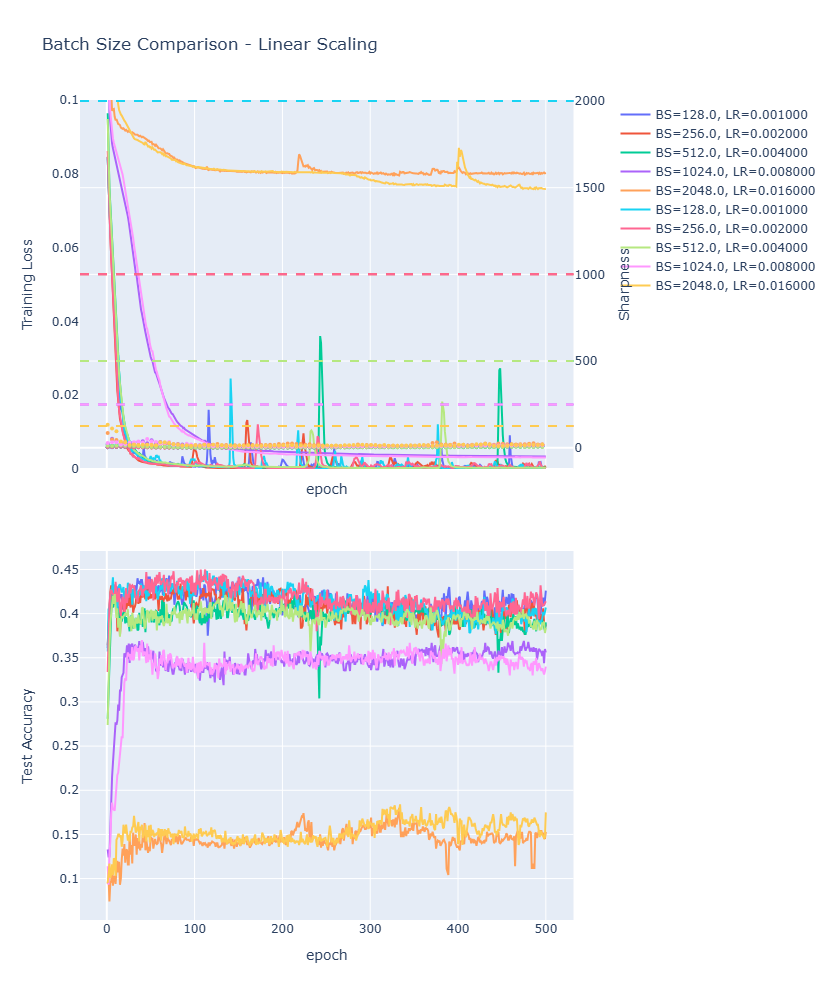

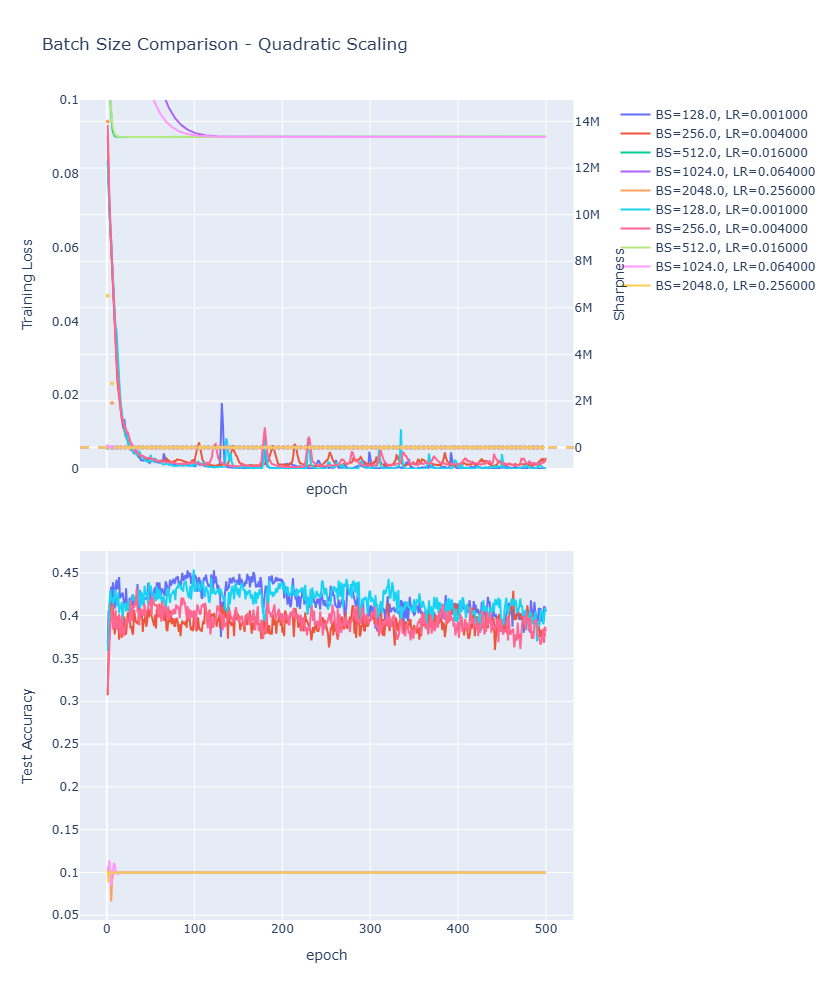

In [14]:
def plot_batch_size_comparison(metadata, output, scaling_rule):
    """Compare batch sizes for a given scaling rule"""
    
    models = metadata[metadata['scaling_rule'] == scaling_rule]
    
    fig = make_subplots(
        rows=2, cols=1, 
        specs=[[{"secondary_y": True}],
               [{"secondary_y": True}]],
        shared_xaxes=True,
        vertical_spacing=0.1
    )
    
    import plotly.express as px
    colors = px.colors.qualitative.Plotly
    
    for idx, (_, model) in enumerate(models.iterrows()):
        model_id = model['model_id']
        batch_size = model['batch_size']
        lr = model['learning_rate']
        
        data = output[output['model_id'] == model_id]
        
        xs = data['epoch'].values
        losses = data['train_loss'].values
        sharpness_H = data['sharpness_H'].values
        test_accuracy = data['test_accuracy'].values
        
        color = colors[idx % len(colors)]
        label = f'BS={batch_size}, LR={lr:.6f}'
        
        # Training Loss
        fig.add_trace(
            go.Scatter(x=xs, y=losses, name=label, line=dict(width=2, color=color)),
            secondary_y=False, row=1, col=1
        )
        
        # Sharpness
        fig.add_trace(
            go.Scatter(x=xs, y=sharpness_H, name=f'BS={batch_size}', 
                      mode='markers', marker=dict(color=color, size=4),
                      showlegend=False),
            secondary_y=True, row=1, col=1
        )
        
        # Test Accuracy
        fig.add_trace(
            go.Scatter(x=xs, y=test_accuracy, name=f'BS={batch_size}',
                      line=dict(width=2, color=color), showlegend=False),
            secondary_y=False, row=2, col=1
        )
        
        # Add 2/η line
        sharpness_H_lim = 2 / lr
        fig.add_hline(y=sharpness_H_lim, line_dash="dash", line_color=color,
                      row=1, col=1, secondary_y=True)
    
    fig.update_yaxes(title_text="Training Loss", secondary_y=False, 
                     range=[0, 0.1], showgrid=False,
                     row=1, col=1)
    fig.update_yaxes(title_text="Sharpness", secondary_y=True, 
                     row=1, col=1)
    
    fig.update_yaxes(title_text="Test Accuracy", secondary_y=False,
                     row=2, col=1)
    
    fig.update_xaxes(title_text="epoch")
    
    fig.update_layout(
        title_text=f"Batch Size Comparison - {scaling_rule.capitalize()} Scaling", 
        height=1000, 
        width=1000
    )
    
    fig.show()

# Use it
plot_batch_size_comparison(md, out, 'linear')
plot_batch_size_comparison(md, out, 'quadratic')

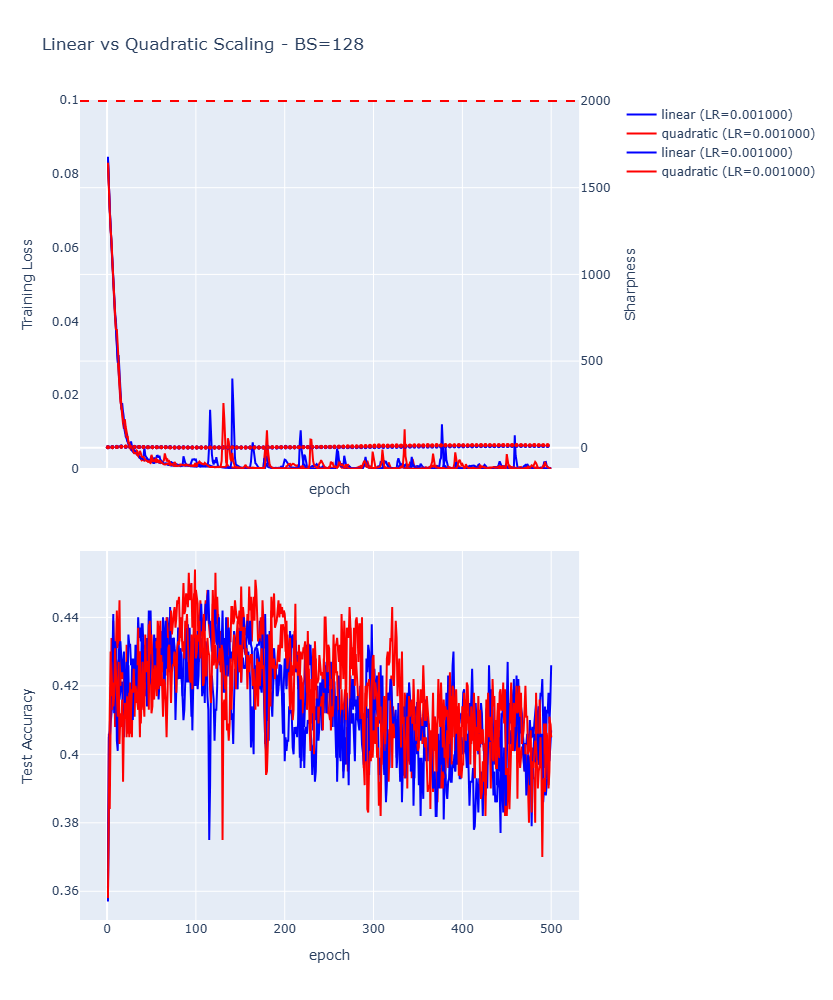

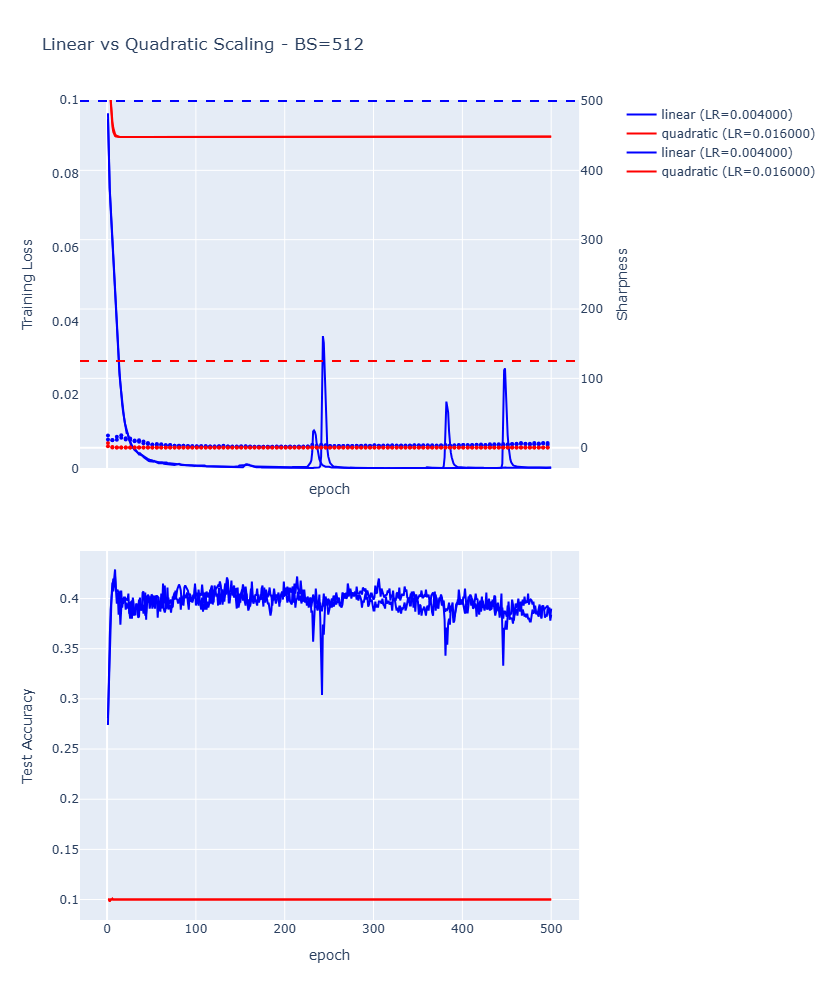

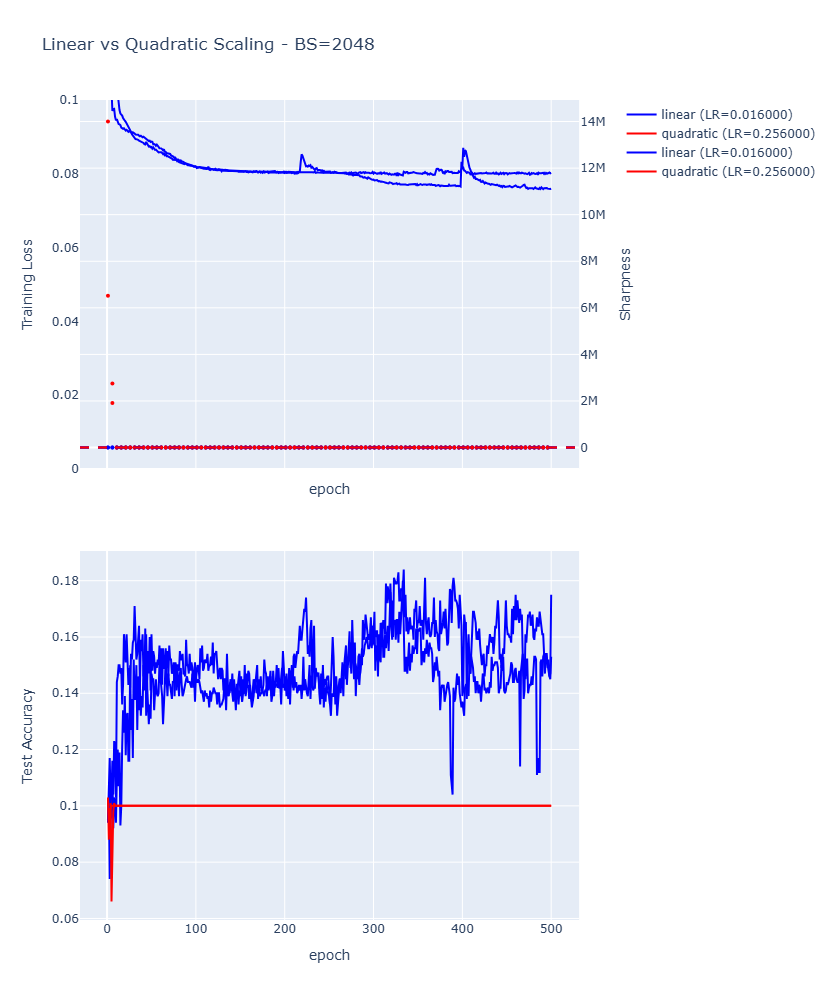

In [15]:
def plot_scaling_comparison(metadata, output, batch_size):
    """Compare linear vs quadratic for a specific batch size"""
    
    models = metadata[metadata['batch_size'] == batch_size]
    
    fig = make_subplots(
        rows=2, cols=1, 
        specs=[[{"secondary_y": True}],
               [{"secondary_y": True}]],
        shared_xaxes=True,
        vertical_spacing=0.1
    )
    
    colors = {'linear': 'blue', 'quadratic': 'red'}
    
    for _, model in models.iterrows():
        model_id = model['model_id']
        scaling = model['scaling_rule']
        lr = model['learning_rate']
        
        data = output[output['model_id'] == model_id]
        
        xs = data['epoch'].values
        losses = data['train_loss'].values
        sharpness_H = data['sharpness_H'].values
        test_accuracy = data['test_accuracy'].values
        
        color = colors[scaling]
        label = f'{scaling} (LR={lr:.6f})'
        
        # Training Loss
        fig.add_trace(
            go.Scatter(x=xs, y=losses, name=label, line=dict(width=2, color=color)),
            secondary_y=False, row=1, col=1
        )
        
        # Sharpness
        fig.add_trace(
            go.Scatter(x=xs, y=sharpness_H, name=f'{scaling}', 
                      mode='markers', marker=dict(color=color, size=4),
                      showlegend=False),
            secondary_y=True, row=1, col=1
        )
        
        # Test Accuracy
        fig.add_trace(
            go.Scatter(x=xs, y=test_accuracy, name=f'{scaling}',
                      line=dict(width=2, color=color), showlegend=False),
            secondary_y=False, row=2, col=1
        )
        
        # Add 2/η line
        sharpness_H_lim = 2 / lr
        fig.add_hline(y=sharpness_H_lim, line_dash="dash", line_color=color,
                      annotation_text=f"{scaling}: 2/η = {sharpness_H_lim:.1f}",
                      row=1, col=1, secondary_y=True)
    
    fig.update_yaxes(title_text="Training Loss", secondary_y=False, 
                     range=[0, 0.1], showgrid=False,
                     row=1, col=1)
    fig.update_yaxes(title_text="Sharpness", secondary_y=True, 
                     row=1, col=1)
    
    fig.update_yaxes(title_text="Test Accuracy", secondary_y=False,
                     row=2, col=1)
    
    fig.update_xaxes(title_text="epoch")
    
    fig.update_layout(
        title_text=f"Linear vs Quadratic Scaling - BS={batch_size}", 
        height=1000, 
        width=1000
    )
    
    fig.show()

# Use it for a few batch sizes
plot_scaling_comparison(md, out, batch_size=128)
plot_scaling_comparison(md, out, batch_size=512)
plot_scaling_comparison(md, out, batch_size=2048)